In [38]:
import numpy as np
import os, sys

from osgeo import gdal
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

In [40]:
def create_mask_from_vector(vector_data_path, cols, rows, geo_transform,
                            projection, target_value=1):
    """Rasterize the given vector (wrapper for gdal.RasterizeLayer)."""
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
    layer = data_source.GetLayer(0)
    driver = gdal.GetDriverByName('MEM')  # In memory dataset
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[target_value])
    return target_ds


def vectors_to_raster(file_paths, rows, cols, geo_transform, projection):
    """Rasterize the vectors in the given directory in a single image."""
    labeled_pixels = np.zeros((rows, cols))
    for i, path in enumerate(file_paths):
        label = i+1
        ds = create_mask_from_vector(path, cols, rows, geo_transform,
                                     projection, target_value=label)
        band = ds.GetRasterBand(1)
        labeled_pixels += band.ReadAsArray()
        ds = None
    return labeled_pixels


def write_geotiff(fname, data, geo_transform, projection):
    """Create a GeoTIFF file with the given data."""
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, gdal.GDT_Byte)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    dataset = None  # Close the file

In [41]:
raster_data_path = "data/image/final.tiff"
output_fname = "classification.tiff"
train_data_path = "data/test/qfaults"
validation_data_path = "data/train/"

In [42]:
raster_dataset = gdal.Open(raster_data_path, gdal.GA_ReadOnly)
geo_transform = raster_dataset.GetGeoTransform()
proj = raster_dataset.GetProjectionRef()
bands_data = []

In [43]:
for b in range(1, raster_dataset.RasterCount+1):
    band = raster_dataset.GetRasterBand(b)
    bands_data.append(band.ReadAsArray())

bands_data = np.dstack(bands_data)
rows, cols, n_bands = bands_data.shape

In [44]:
print(rows, cols, n_bands)

7831 7711 11


In [62]:
# plt.subplot(1, n_ba, i+1)
plt.pcolor(bands_data[:, :, 9])
plt.title('Band: {}'.format(10))
plt.tight_layout()
plt.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py", line 3223, in pcolor
    ret = ax.pcolor(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py", line 1898, in inner
    return func(ax, *args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py", line 5408, in pcolor
    axis=1)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-62-9c2dea85a894>", line 2, in <module>
    plt.pcolor(bands_data[:, :, 9])
  File "/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py", line 3223, in pcolor
    ret = ax.pcolor(*args, **kwargs)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Trace


KeyboardInterrupt



In [49]:
files = [f for f in os.listdir(train_data_path) if f.endswith('.shp')]
classes = [f.split('.')[0] for f in files]
shapefiles = [os.path.join(train_data_path, f)
              for f in files if f.endswith('.shp')]

In [50]:
labeled_pixels = vectors_to_raster(shapefiles, rows, cols, geo_transform, proj)

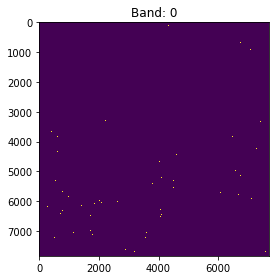

In [51]:
plt.imshow(labeled_pixels)
plt.title('Band: {}'.format(0))
plt.tight_layout()
plt.show()

In [52]:
is_train = np.nonzero(labeled_pixels)

In [60]:
len(is_train[0])

67500

In [53]:
training_labels = labeled_pixels[is_train]
training_samples = bands_data[is_train]

In [54]:
classifier = RandomForestClassifier(n_jobs=-1)
classifier.fit(training_samples, training_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [55]:
n_samples = rows*cols
flat_pixels = bands_data.reshape((n_samples, n_bands))
result = classifier.predict(flat_pixels)
classification = result.reshape((rows, cols))

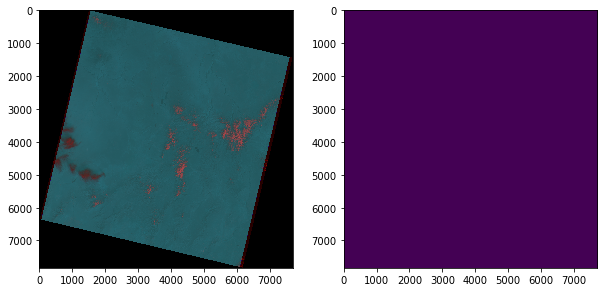

In [56]:
f = plt.figure(figsize=(10, 5))
f.add_subplot(1, 2, 2)
r = bands_data[:,:,3]
g = bands_data[:,:,2]
b = bands_data[:,:,1]
rgb = np.dstack([r,g,b])
f.add_subplot(1, 2, 1)
plt.imshow(rgb/255)
f.add_subplot(1, 2, 2)
plt.imshow(classification)
plt.show()

In [57]:
write_geotiff(output_fname, classification, geo_transform, proj)